# De-Identification Pipeline

## Introduction

This notebook presents a demonstration of the de-identification workflow. It demonstrates how a raw document is converted into a de-identified, model-safe representation by tagging PHI at the text level, projecting those tags back onto Textract word boxes, and then scrubbing the corresponding pixels on the original page image (this is for humans not our model).

## De-ID Pipeline Overview

1. **Document Input**  
   The pipeline starts with a document page image (or PDF rendered to images).

2. **OCR with Amazon Textract**  
   The document is processed with Textract to produce a raw JSON file containing WORD and LINE blocks with text, bounding boxes, and reading-order relationships.

3. **Page Text Reconstruction + Span Mapping**  
   For each page, the Textract WORDs are reassembled into a clean text string in reading order. While building the string, the notebook records a character span for every WORD block (word_id → (start, end)), creating an alignment map between Azure offsets and Textract word IDs.

4. **PHI Tagging with Azure De-Identification (TAG Mode)**  
   The reconstructed page text is sent to Azure’s PHI tagger. Azure returns entity spans as (category, offset, length) within the page text. (we have multiple options here)

5. **Project Entity Spans Back to Textract WORD Blocks**  
   The Azure entity spans are mapped back onto Textract WORD blocks by checking span overlap against the saved word_id → (start, end) spans. Any WORD that overlaps an entity span is flagged for redaction.
6. **Patch Textract JSON with Placeholders + Audit Flags**  
   Identified WORD blocks have their Text replaced with a normalized placeholder (e.g., [name], [date], [id], [phone]) and are marked with deid_altered = True. LINE text is rebuilt from the updated WORDs so the JSON is internally consistent.
7. **Create Model-Ready Samples + Scrubbed Images**  
   The patched Textract JSON is converted into one sample per page (samples.jsonl) containing words, pixel-space bounding boxes, edited flags, and redaction types. Using those boxes, the original page image is scrubbed by drawing black rectangles over redacted words, producing a de-identified PNG suitable for storage, debugging, and downstream modeling.

## End-to-End Demonstration

Load dependencies, setup notebook path, initilize file paths

In [11]:
import json
import os
import random
import sys, subprocess
from pathlib import Path
from typing import Dict, List, Optional
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U",
                       "azure-identity",
                       "azure-health-deidentification"])
# notebook path setup
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print(ROOT)

from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

from azure.identity import DefaultAzureCredential
from azure.health.deidentification import DeidentificationClient
from azure.health.deidentification.models import DeidentificationContent, DeidentificationOperationType

from scripts.deidentify import build_clean_text_and_spans_by_page, compute_word_replacements_from_entities, apply_word_replacements, setup_paths, tag_entities
from scripts.overlayscrub import textract_to_samples, write_jsonl, scrub_sample_to_image, setup_paths_overlay





endpoint = (
        os.environ.get("AZURE_HEALTH_DEIDENTIFICATION_ENDPOINT")
        or os.environ.get("HEALTHDATAAISERVICES_DEID_SERVICE_ENDPOINT")
        or "https://ama0aehpg9a2bfg8.api.eus001.deid.azure.com"
    )
img_path = ROOT / "docfusion_lite" / "data" / "textracttest" / "form-wh-380-e-813x1024-hw.jpg"
root, textract_json_path, out_dir = setup_paths()

c:\Users\luke6\Desktop\DocFusionLite


We begin with a synthetic FMLA document image representing raw, unstructured input. In a real-world setting, this document would contain real protected health information (PHI) and is therefore unsuitable for direct training.

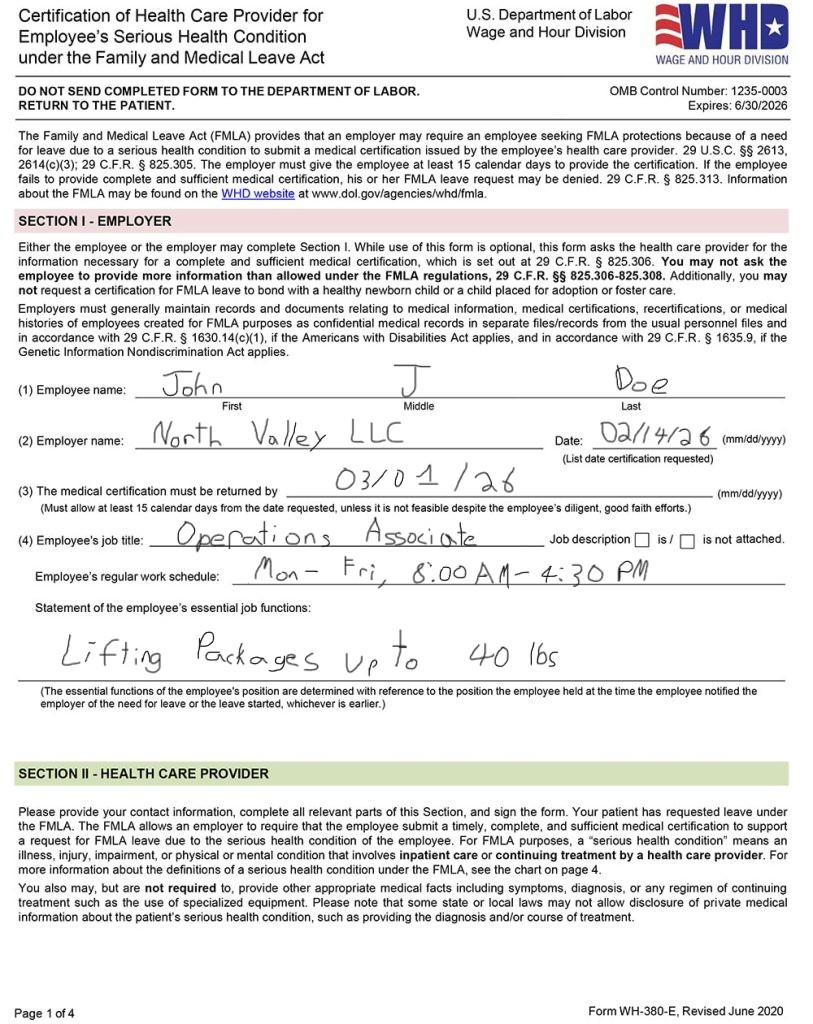

In [20]:
img = Image.open(img_path)
display(img)

After loading the image, we pass it through Amazon Textract. This outputs a large JSON file that contains:
- A list of OCR “Blocks” (e.g., `LINE`, `WORD`, and other document elements)
- Extracted text for each block and basic text metadata (e.g., `TextType`)
- Normalized geometric information

Once we have our textract output we use `build_clean_text_and_spans_by_page` to recreate the original input text in the order anf formatting of the original document.

In [13]:
textract = json.loads(textract_json_path.read_text(encoding="utf-8"))
pages = build_clean_text_and_spans_by_page(textract)
(out_dir / "azure_tag_inputs.json").write_text(json.dumps(pages, indent=2), encoding="utf-8")

55648

Next we call Azure de-identification in TAG mode on each page’s reconstructed text (or loads cached results from azure_tag_outputs.json) and stores per-page entity spans for later word-level mapping. 

TAG mode outputs entity metadata only. For each detected PHI element it returns: 
- category (e.g., name, date, id, phone) 
- offset and length (character span in the input text)
it does not modify the text

Other options (briefly):
- REDACT: returns the text with detected PHI removed or masked (no offsets). 
- REPLACE / SURROGATE: returns text where PHI is replaced with synthetic values (e.g., names, dates). 
- OFF: no de-identification (pass-through).

In production we most use surrogation as this preserves document structure and readability while removing sensitive identifiers, essentially giving us the best of both worlds

TAG is used in this scenario as it is the easiest to visually overlay

In [23]:
outputs_path = out_dir / "azure_tag_outputs.json"
if outputs_path.exists():
    azure_outputs = json.loads(outputs_path.read_text(encoding="utf-8"))
else:
    client = DeidentificationClient(endpoint, DefaultAzureCredential())
    azure_outputs = []
    for p in pages:
        entities = tag_entities(client=client, text=p["text"])
        azure_outputs.append({"page": int(p["page"]), "entities": entities})
    outputs_path.write_text(json.dumps(azure_outputs, indent=2), encoding="utf-8")

page_map = {int(p["page"]): p for p in pages}

Now we map Azure entity spans back to Textract WORD IDs, replaces overlapping words with normalized placeholders, flags altered words (deid_altered), and writes a patched, de-identified Textract JSON for downstream processing.

In [24]:
all_word_replacements: Dict[str, str] = {}
for p in azure_outputs:
    page_num = int(p.get("page", 1))
    entities = p.get("entities", []) or []
    word_spans = (page_map.get(page_num) or {}).get("word_spans", {}) or {}
    all_word_replacements.update(
        compute_word_replacements_from_entities(word_spans=word_spans, entities=entities)
    )

In [25]:
deid_textract = apply_word_replacements(
    textract=textract,
    word_id_to_new=all_word_replacements,
    altered_flag_key="deid_altered",
)

out_textract_path = out_dir / f"{textract_json_path.stem}_deid.json"
out_textract_path.write_text(json.dumps(deid_textract, indent=2), encoding="utf-8")

print(f"patched WORDs: {len(all_word_replacements)}")
print(f"wrote: {out_textract_path}")


patched WORDs: 23
wrote: C:\Users\luke6\Desktop\DocFusionLite\scripts\azuredeid\out_detect_hw_deid.json


Finally we convert the de-identified Textract JSON into model-ready page samples (samples.jsonl) and create scrubbed page images by blacking out all words marked as altered, producing fully de-identified visual and textual artifacts.

Its important to note that at this point the output could be plugged directly into the model.

In [17]:
TEXTRACT_JSON_PATH, IMAGE_PATHS_BY_PAGE, OUT_DIR, ALTERED_FLAG_KEY = setup_paths_overlay()

samples = textract_to_samples(
    textract_json_path=TEXTRACT_JSON_PATH,
    image_paths_by_page=IMAGE_PATHS_BY_PAGE,
    altered_flag_key=ALTERED_FLAG_KEY,
)

In [18]:
write_jsonl(samples, OUT_DIR / "samples.jsonl")

for s in samples:
    page = int(s.get("page", 1))
    scrub_sample_to_image(s, OUT_DIR / f"scrubbed_page{page}.png")

print(f"wrote: {OUT_DIR / 'samples.jsonl'}")
print(f"wrote scrubbed images to: {OUT_DIR}")


wrote: C:\Users\luke6\Desktop\DocFusionLite\scripts\azuredeid\samples.jsonl
wrote scrubbed images to: C:\Users\luke6\Desktop\DocFusionLite\scripts\azuredeid


As shown below, all PHI has been removed from the document, allowing us to proceed with model training.

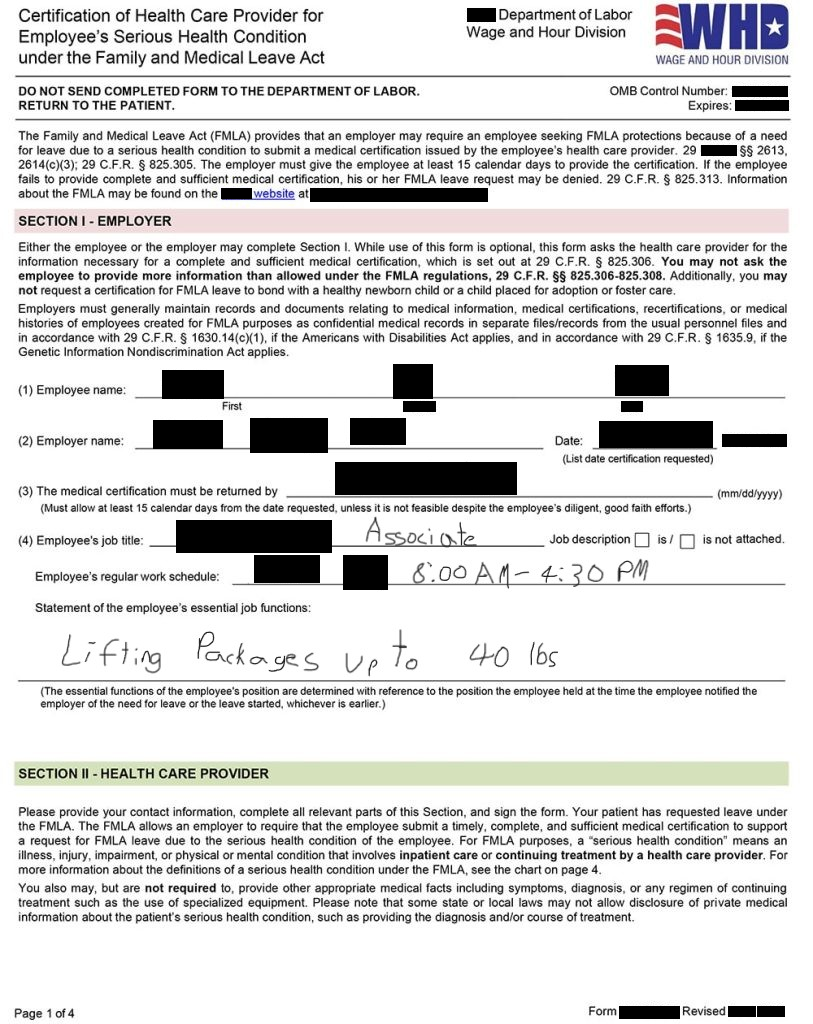

In [19]:
img = Image.open(OUT_DIR / f"scrubbed_page1.png")
display(img)